<a href="https://colab.research.google.com/github/HumphreyChou/CLIC-2021-Learned-Image-Compression/blob/main/CLIC2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIC2021

此笔记本是私人的，你可以在此处运行代码，但是所有结果不会被保存，
选择：文件 > 在云端硬盘中保存一份副本 可以创建你自己的笔记本

使用时一定选择 修改 > 笔记本设置 > 硬件加速器 GPU

## 环境配置
挂载云端硬盘
将自己的云端硬盘挂载在 colab 虚拟机文件系统下，可以使用自己上传的代码并保存训练数据

In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


切换到当前工作路径

In [26]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/CLIC2021")

### 安装配置 Anaconda

In [ ]:
# !wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
!bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local
!conda update -y -q
!conda env list

In [ ]:
!conda install -y -q python=3.7 cudatoolkit=10.0 cudnn

In [5]:
import sys
sys.path.insert(0, "/usr/local/lib/python3.7/site-packages/")
!source /usr/local/etc/profile.d/conda.sh
!source ~/.bashrc

检查 python 版本，运行结果应该为 `Python 3.7.*`

In [6]:
!python --version

Python 3.7.10


### 上传代码
此处使用修改后的 Google HiFiC 代码



In [ ]:
!git clone https://github.com/HumphreyChou/compression.git

### 安装第三方包

In [ ]:
%%shell
cd compression/models/

pip install -r hific/requirements.txt
pip install scipy

## 训练

In [29]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/CLIC2021/compression/models")

先训练 MSE + LPIPS 模型

In [ ]:
%%shell
python -m hific.train --config mselpips --ckpt_dir ../../ckpts/mse_lpips \
    --num_steps 1k --tfds_dataset_name cifar10 --no-image-summaries


再训练 GAN 模型

In [ ]:
%%shell
python -m hific.train --config hific --ckpt_dir ../../ckpts/hific \
                --init_autoencoder_from_ckpt_dir ../../ckpts/mse_lpips \
                --num_steps 10k \
                --tfds_dataset_name cifar10 \
                --no-image-summaries

## 评估

生成压缩图像，计算 PSNR 与 bpp

In [ ]:
%%shell
python -m hific.evaluate --config hific \
                   --ckpt_dir ../../ckpts/hific \
                   --out_dir ../../out \
                   --tfds_dataset_name cifar10 \
                   --max_image 100

## 压缩你自己的图像

- 点击 文件 > 上传到会话存储空间，上传图片（png 格式）
- 在下面填入图片名
- 原图像与压缩后图像会保存在云盘中 `usr_out` 目录下


In [ ]:
%%shell
IMAGE_PATH=/content/# 图片名 # 
python -m hific.evaluate --config hific \
                   --ckpt_dir ../../ckpts/hific \
                   --out_dir ../../usr_out \
                   --images_glob ${IMAGE_PATH} \
                   --max_image 100

查看图像对比

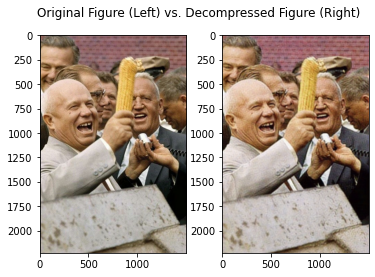

In [38]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

inp_filename = glob.glob('/content/drive/My Drive/Colab Notebooks/CLIC2021/usr_out/*inp.png')[0]
otp_filename = glob.glob('/content/drive/My Drive/Colab Notebooks/CLIC2021/usr_out/*otp.png')[0]
inp = mpimg.imread(inp_filename)
otp = mpimg.imread(otp_filename)

plt.figure()
plt.subplot(1,2,1)
plt.suptitle('Original Figure (Left) vs. Decompressed Figure (Right)')
plt.imshow(inp)
plt.subplot(1,2,2)
plt.imshow(otp)
plt.show()

## 打扫战场
配置环境、训练过程中会占用硬盘空间，直到占满。colab运行在虚拟机上，且训练产生出的参数和 checkpoint 存储在 ckpt_dir（可以是你指定的云端磁盘位置），因此可以直接选择 代码执行程序 > 将该运行时恢复出厂设置，即可被分配新的虚拟机，和所有的烦恼说拜拜

实际上，被分配的虚拟机存活时间最长12小时，即12小时后一切配置都会重置，这是谷歌的动态分配策略，以保证免费资源供应